In [ ]:
# Install required packages
!pip install -q transformers datasets sentencepiece
!pip install -q pytorch-lightning wandb
!pip install -q donut-python

# !huggingface-cli login this shouldh be done from the terminal

In [1]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("Jac-Zac/thesis_test_donut")
model = VisionEncoderDecoderModel.from_pretrained("Jac-Zac/thesis_test_donut")

In [33]:
import re
import json
import torch
from tqdm.auto import tqdm
import numpy as np
import random
from PIL import Image

from donut import JSONParseEvaluator
from datasets import load_dataset

device = "cuda" if torch.cuda.is_available() else "cpu"

model.eval()
model.to(device)

output_list = []
accs = []

image_path = "/Users/jaczac/Github/Thesis/donut_example/copy/img_resized"

dataset = load_dataset(image_path, split="validation")


for idx, sample in tqdm(enumerate(dataset), total=len(dataset)):
    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_herbarium>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)
    
    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    evaluator = JSONParseEvaluator()
    score = evaluator.cal_acc(seq, ground_truth)

    accs.append(score)
    output_list.append(seq)

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

Resolving data files:   0%|          | 0/1462 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/184 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/jaczac/.cache/huggingface/datasets/imagefolder/img_resized-45137e88c492ea73/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/183 [00:00<?, ?it/s]

{'accuracies': [0.7567567567567568, 0.45945945945945943, 0.9915966386554622, 0.652542372881356, 0.624113475177305, 0.9404761904761905, 0.9052631578947369, 0.7916666666666666, 0.8333333333333334, 1.0, 0.4195804195804196, 0.5689655172413793, 1.0, 0.989010989010989, 1.0, 1.0, 0.6985294117647058, 0.9811320754716981, 0.9915966386554622, 0.7304347826086957, 0.9885057471264368, 0.950354609929078, 1.0, 1.0, 0.3933333333333333, 0.4492753623188406, 0.21126760563380287, 0.6037735849056604, 1.0, 1.0, 0.8378378378378378, 0.9904761904761905, 0.1477272727272727, 0.9866666666666667, 0.8405797101449275, 0.9365079365079365, 0.9857142857142858, 0.9855072463768116, 0.96875, 0.9895833333333334, 0.9891304347826086, 0.9875, 0.3026315789473685, 1.0, 0.8977272727272727, 0.8809523809523809, 0.8673469387755102, 0.8137254901960784, 0.990909090909091, 0.9789473684210527, 0.9789473684210527, 0.6421052631578947, 0.971830985915493, 0.978021978021978, 0.85, 0.46376811594202894, 0.8235294117647058, 0.7096774193548387, 

In [34]:
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.8448091318428346


Ground Truth: {"Nome_verbatim": "Athyrium filix-femina (L.) Roth\n", "Nome_floritaly": "Athyrium filix-femina\n(L.) Roth", "Luogo_Raccolta": "Ekeberg", "Altitudine": " ", "Giorno": 2, "Mese": 8.0, "Anno": 1943.0}

Prediction: {'Nome_verbatim': 'Asplenium fluetum fluetum fluetum flue', 'Nome_floritaly': 'Asplenium fluoretum fluorehum L. subsp. fluorehum', 'Luogo_Raccolta': 'Val Fleuris', 'Altitudine': '', 'Giorno': '2', 'Mese': '8.0', 'Anno': '1975.0'}

Score: 0.10465116279069764



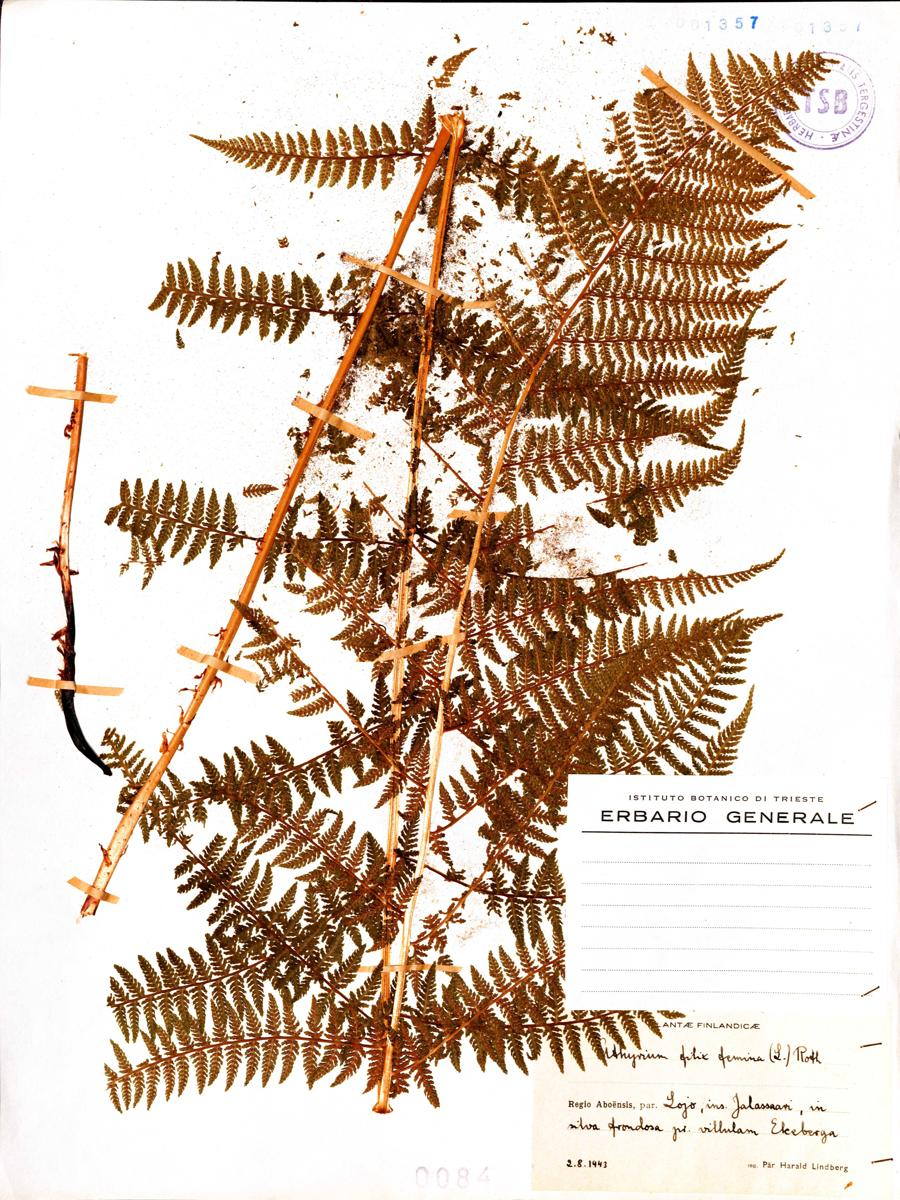

Ground Truth: {"Nome_verbatim": "Cystopteris fragilis (L.) Bernh. x Cystopteris alpina (Lam) Desv.", "Nome_floritaly": "Cystopteris fragilis (L.) Bernh. Cystopteris alpina (Lam.) Desv.\n", "Luogo_Raccolta": "Creta di Mimoias\n", "Altitudine": 1880, "Giorno": 8, "Mese": 9.0, "Anno": 1973.0}

Prediction: {'Altitudine': '1880', 'Giorno': '8', 'Mese': '9.0', 'Anno': '1973.0'}

Score: 0.10843373493975905



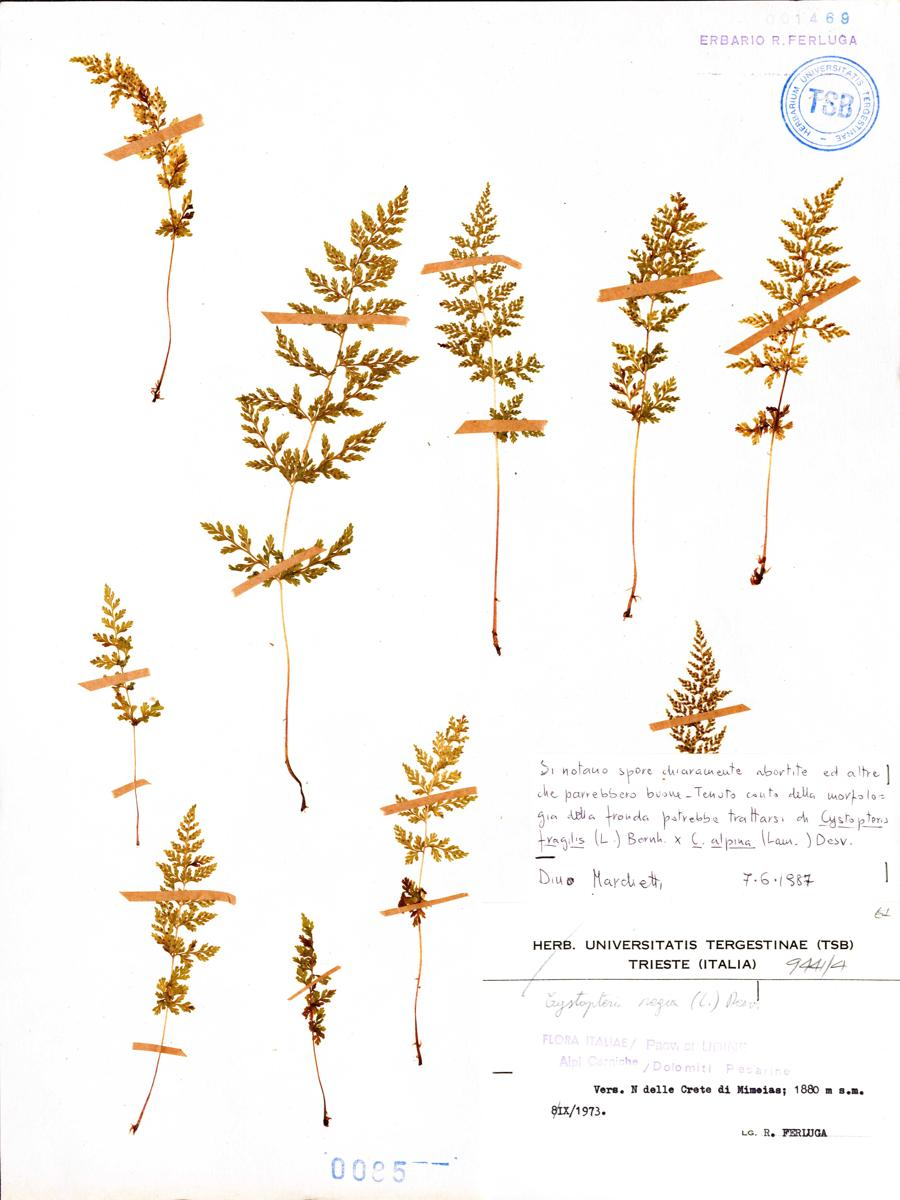

Ground Truth: {"Nome_verbatim": "Equisetum fluviatile L.; Ehrh.", "Nome_floritaly": "Equisetum fluviatile L.\n", "Luogo_Raccolta": "Pyh\u00e4lt\u00f6, Finlandia", "Altitudine": " ", "Giorno": 3, "Mese": 7.0, "Anno": 1966.0}

Prediction: {'Nome_verbatim': 'Dryopteris officinarum L. Ehrh', 'Nome_floritaly': 'Dryopteris villarii (L.) A.Haines subsp. villarii', 'Luogo_Raccolta': 'Lago di Farana', 'Altitudine': '', 'Giorno': '3', 'Mese': '7.0', 'Anno': '1966.0'}

Score: 0.1477272727272727



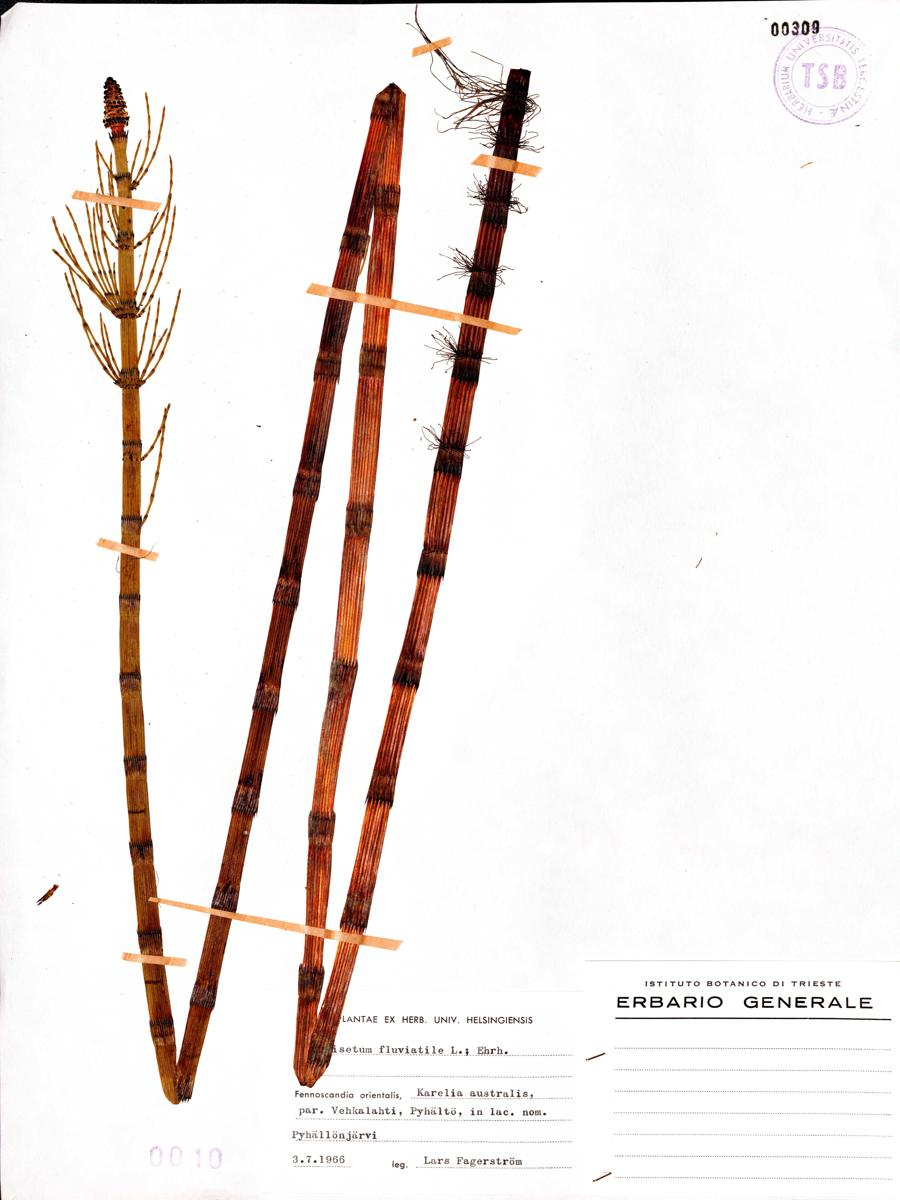

Ground Truth: {"Nome_verbatim": "Azolla filiculoides Lam.", "Nome_floritaly": "Azolla filiculoides Lam", "Luogo_Raccolta": "Kapelle", "Altitudine": 3, "Giorno": 27, "Mese": 5.0, "Anno": 1975.0}

Prediction: {'Nome_verbatim': 'Asplenium fissum Kit.', 'Nome_floritaly': 'Asplenium fissum Kit. ex Willd.', 'Luogo_Raccolta': 'Lago di Flame', 'Altitudine': '300', 'Giorno': '22', 'Mese': '8.0', 'Anno': '1987.0'}

Score: 0.20547945205479456



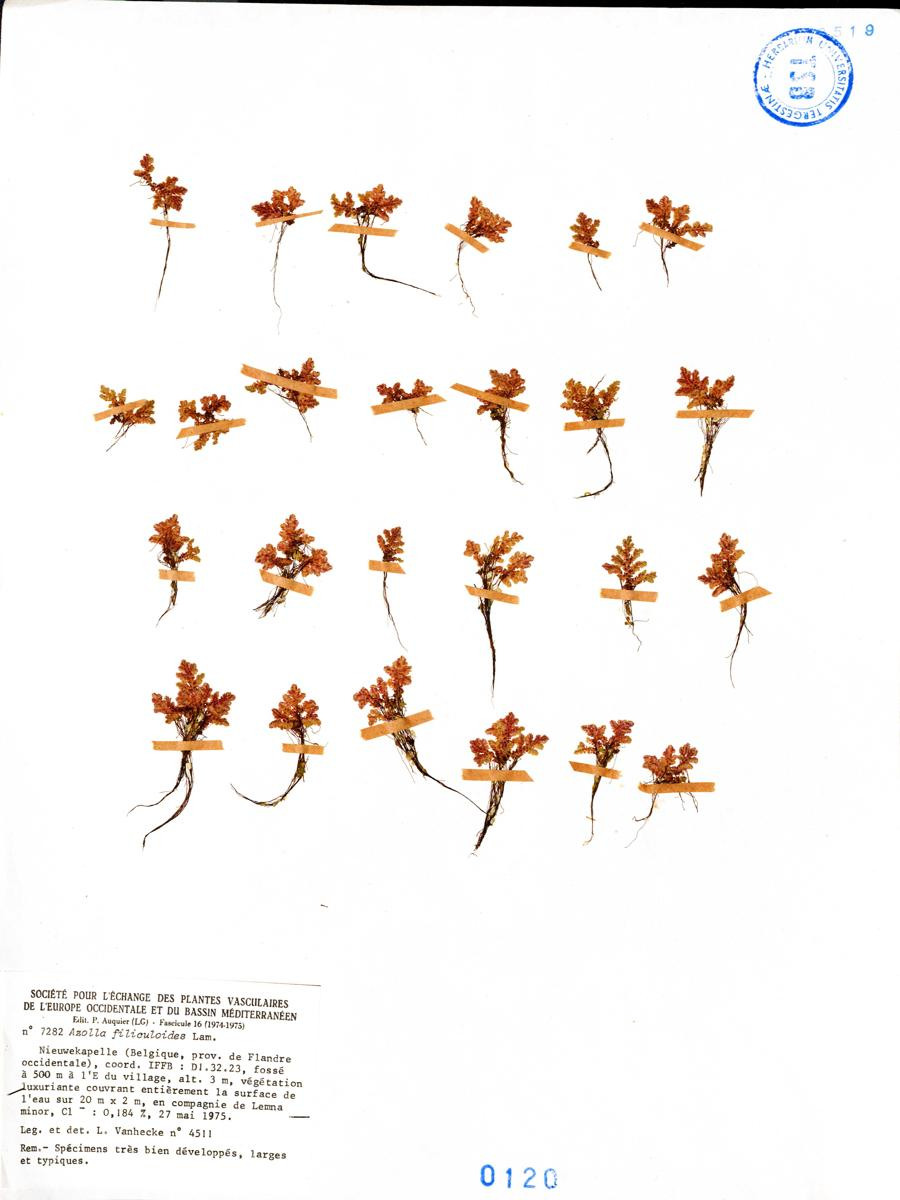

Ground Truth: {"Nome_verbatim": "Isoetes histrix", "Nome_floritaly": "Iso\u00ebtes histrix Bory\n", "Luogo_Raccolta": "stagno di Aureilhan", "Altitudine": " ", "Giorno": 2, "Mese": 5.0, "Anno": 1977.0}

Prediction: {'Nome_verbatim': 'Pilularia australe', 'Nome_floritaly': 'Pilularia alpestre (Hoppe) Nyl.', 'Luogo_Raccolta': 'Poluce di Cormons', 'Altitudine': '', 'Giorno': '12', 'Mese': '4.0', 'Anno': '1977.0'}

Score: 0.21126760563380287



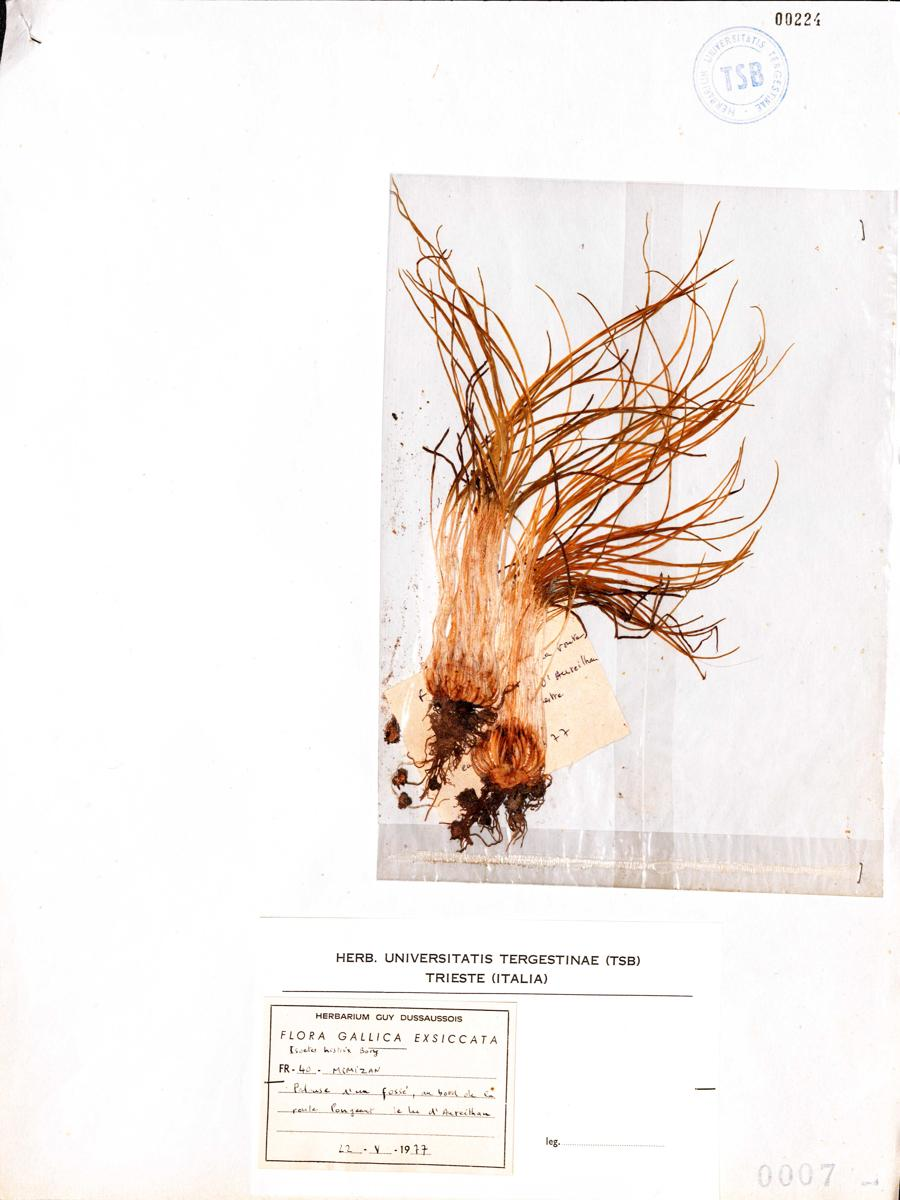

In [35]:
# get indices of worst 5 predictions
worst_idxs = np.argsort(accs)[:5].tolist()

# prepare decoder inputs
task_prompt = "<s_herbarium>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
decoder_input_ids = decoder_input_ids.to(device)

for idx in worst_idxs:
    sample = dataset[idx]

    # prepare encoder inputs
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
        pixel_values,
        decoder_input_ids=decoder_input_ids,
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)
    
    print(f"Ground Truth: {sample['ground_truth']}\n")
    print(f"Prediction: {seq}\n")
    print(f"Score: {accs[idx]}\n")
    display(sample["image"])